In [1]:
%%capture
import os
import time
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
ARGO_DIR = '/data/datos/ARGO/data/'
argo_files = [os.path.join(ARGO_DIR,x) for x in os.listdir(ARGO_DIR) if x.endswith('_prof.nc')]

In [69]:
def get_hist(file, lats, lons):
    data = xr.open_dataset(file)
    mask = (data.LATITUDE < lats[0]) & (data.LATITUDE > lats[1]) & (data.LONGITUDE > lons[0]) & (data.LONGITUDE < lons[1])
    lat = data.LATITUDE[mask].data
    lon = data.LONGITUDE[mask].data
    pfid = data.PLATFORM_NUMBER.load()[mask].data.astype(int)
    stack = np.stack([lat,lon,pfid],axis=1)
    date = pd.to_datetime(data.JULD[0].data).date()
    return pd.DataFrame(stack, index = [np.repeat(date,len(stack))], columns=['lat','lon','pfid'])

In [91]:
ninodf = [get_hist(data_file,[0,-10],[-90,-80]) for data_file in argo_files[-370:]]
ninodf = pd.concat(ninodf)
ninodf.head()

,lat,lon,pfid
2018-01-28,-5.63214,-83.63657,3901056.0
2018-01-28,-7.98500,-85.20200,6902673.0
2018-01-28,-4.77691,-83.06220,3901267.0
2018-01-30,-1.92295,-89.14813,3901233.0
2018-01-31,-1.35661,-87.74189,3901262.0


In [105]:
x_grid = np.linspace(-90, -80, 4)
y_grid = np.linspace(-10, 0, 4)
H, xedges, yedges =np.histogram2d(ninodf['lon'], ninodf['lat'], bins=(x_grid, y_grid))
H = H.T

In [143]:
def get_hist(dataf):
    H, xedges, yedges =np.histogram2d(dataf['lon'], dataf['lat'], bins=(x_grid, y_grid))
    H = H.T.flatten()
    return pd.Series(data=H,index=np.arange(1,10))

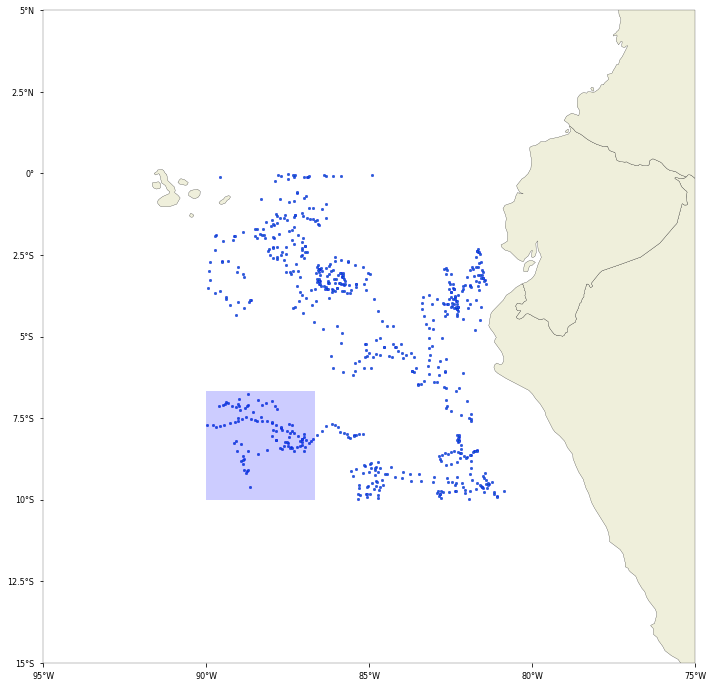

In [134]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.add_patch(mpatches.Rectangle(xy=[x_grid[0], y_grid[0]], width=x_grid[1]-x_grid[0], height=y_grid[1]-y_grid[0],
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))

hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
ax.add_feature(hq_border)
ax.set_extent([85, 105, -15, 5], crs=proj)

draw = ax.scatter(ninodf['lon'], ninodf['lat'], s=6,edgecolor='b',lw=0.4,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu'))
# cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),np.max(H),10))
# cbar.ax.tick_params(labelsize=15) 

In [130]:
H

array([[101.,  65.,  97.],
       [ 24.,  90.,  86.],
       [112.,  59.,  34.]])

In [127]:
H.flatten().shape

(9,)

In [145]:
new_hist = ninodf.groupby(ninodf.index).apply(get_hist)
new_hist.head()

,1,2,3,4,5,6,7,8,9
2018-01-28,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2018-01-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-01-31,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
2018-02-01,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2018-02-02,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


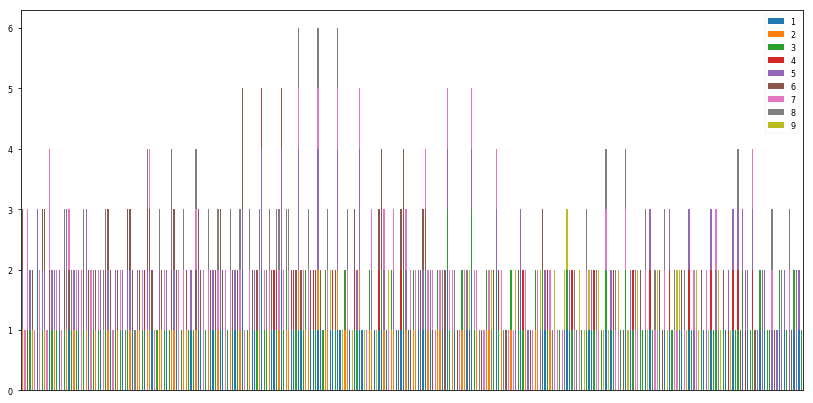

In [193]:
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

df = new_hist
fig, ax = plt.subplots(figsize=(14,7))
df.plot.bar(stacked = True, ax=ax)
# ax.xaxis_date()
# ax.set_xticklabels(df.index.strftime('%Y-%m'))
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# fig.autofmt_xdate()
# new_hist.iloc[-20:].plot.bar(stacked = True)